In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

2022-07-06 22:28:41.439830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 22:28:41.439856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def powerlaw(x, slope, lo, hi):
    
    return (
        (x >= lo) * (x <= hi)
        * x**slope
        * (slope+1) / (hi**(slope+1) - lo**(slope+1))
        )

def sample_powerlaw(n_samples, slope, lo, hi):
    
    x = np.random.uniform(size=n_samples)
    
    return (lo**(slope+1) + x * (hi**(slope+1) - lo**(slope+1)))**(1/(slope+1))

In [3]:
n_slopes = 10
slopes = np.linspace(0, 5, n_slopes)

n_samples = 10000
lo = 0
hi = 1
data = sample_powerlaw(n_samples, slopes[:, None], lo, hi)
data.shape

(10, 10000)

In [4]:
slopes = np.repeat(slopes[:, None], n_samples, axis=1)
slopes.shape

(10, 10000)

In [5]:
data = np.concatenate(data)
slopes = np.concatenate(slopes)
data.shape, slopes.shape

((100000,), (100000,))

In [6]:
# https://github.com/tensorflow/probability/issues/1410
# https://github.com/tensorflow/probability/issues/1006#issuecomment-663141106

import re

def make_bijector_kwargs(bijector, name_to_kwargs):
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

In [7]:
n_flows = 3
n_layers = 1
n_units = 128

activation = 'relu'

bijectors = []

bijectors.append(tfb.Scale(scale=.5))
bijectors.append(tfb.Shift(shift=1.))
bijectors.append(tfb.Tanh())

for i in range(n_flows):
    bijectors.append(tfb.MaskedAutoregressiveFlow(
        tfb.AutoregressiveNetwork(
            params=2,
            event_shape=(1,),
            conditional=True,
            conditional_event_shape=(1,),
            hidden_units=[n_units]*n_layers,
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6),
            bias_regularizer=tf.keras.regularizers.L2(l2=1e-6),
            ),
        name=f'maf{i}',
        ))
    #bijectors.append(tfb.BatchNormalization())
    bijectors.append(tfb.Permute(list(reversed(range(1)))))
    
bijector = tfb.Chain(bijectors)
distribution = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[1])
nf = tfd.TransformedDistribution(distribution=distribution, bijector=bijector)

x = tf.keras.Input(shape=(1,), dtype=tf.float32)
c = tf.keras.Input(shape=(1,), dtype=tf.float32)

log_prob = nf.log_prob(
    x,
    bijector_kwargs=make_bijector_kwargs(
        nf.bijector, {'maf.': {'conditional_input': c}},
        ),
    )

model = tf.keras.Model([x, c], log_prob)

2022-07-06 22:28:43.067869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 22:28:43.067909: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 22:28:43.067929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (phy-190401): /proc/driver/nvidia/version does not exist
2022-07-06 22:28:43.068717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
epochs = 20
batch_size = 1000
learning_rate = 1e-3

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=lambda _, log_prob: -log_prob,
    )

result = model.fit(
    x=[data, slopes],
    y=np.zeros(n_samples*n_slopes, dtype=np.float32),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1,
    )

Epoch 1/20
100/100 [==============================] - 2s 6ms/step - loss: 2.1895
Epoch 2/20
100/100 [==============================] - 1s 6ms/step - loss: 0.1094
Epoch 3/20
100/100 [==============================] - 1s 6ms/step - loss: -0.4483
Epoch 4/20
100/100 [==============================] - 1s 6ms/step - loss: -0.4571
Epoch 5/20
100/100 [==============================] - 1s 6ms/step - loss: -0.4610
Epoch 6/20
100/100 [==============================] - 1s 6ms/step - loss: -0.4634
Epoch 7/20
100/100 [==============================] - 1s 7ms/step - loss: -0.4655
Epoch 8/20
100/100 [==============================] - 1s 7ms/step - loss: -0.4661
Epoch 9/20
100/100 [==============================] - 1s 6ms/step - loss: -0.4666
Epoch 10/20
100/100 [==============================] - 1s 6ms/step - loss: -0.4671
Epoch 11/20
100/100 [==============================] - 1s 6ms/step - loss: -0.4674
Epoch 12/20
100/100 [==============================] - 1s 6ms/step - loss: -0.4670
Epoch 13/20
100

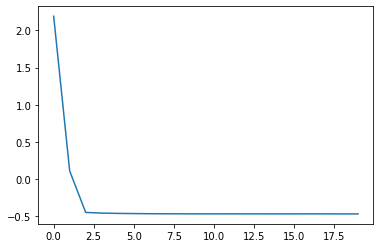

In [9]:
plt.plot(result.history['loss']);

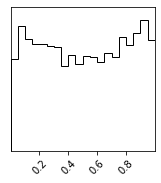

In [10]:
corner(nf.sample(
    10000,
    bijector_kwargs=make_bijector_kwargs(
        nf.bijector, {'maf.': {'conditional_input': 0*np.ones((10000,1))}},
        ),
    ).numpy());                  

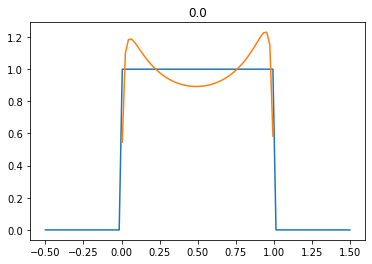

/tmp/ipykernel_13114/2647822554.py:5: RuntimeWarning: invalid value encountered in power
  * x**slope


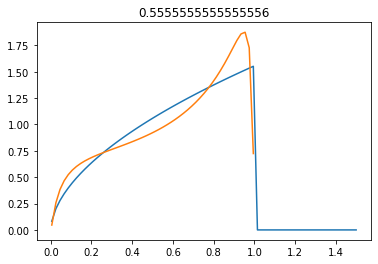

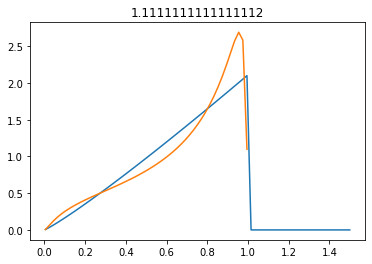

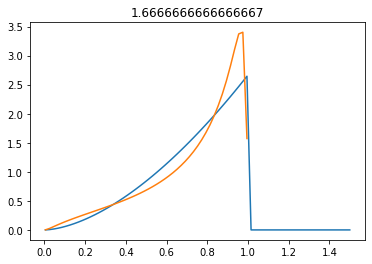

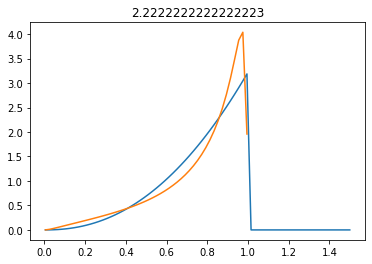

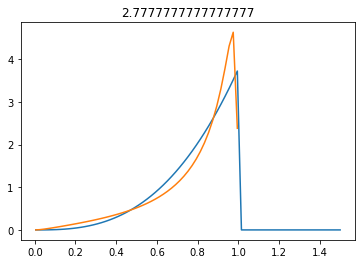

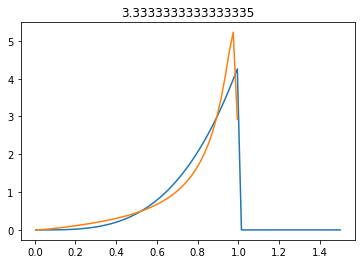

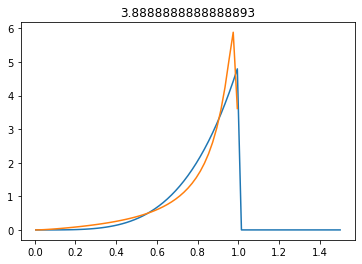

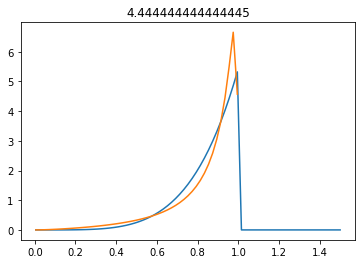

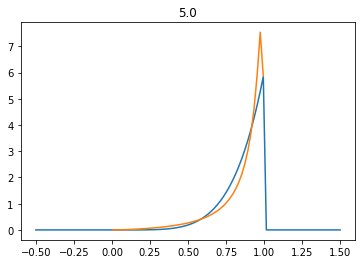

In [11]:
n = 100

x = np.concatenate(np.repeat(
    np.linspace(lo-.5, hi+.5, n)[None, :], n_slopes, axis=0,
    ))[:, None]
c = np.concatenate(np.repeat(
    np.unique(slopes)[:, None], n, axis=1,
    ))[:, None]

p = np.exp(nf.log_prob(
    x,
    bijector_kwargs=make_bijector_kwargs(
        nf.bijector, {'maf.': {'conditional_input': c}},
        ),
    )).reshape(n_slopes, n)

x = np.unique(x)
c = np.unique(c)
for i, (p_, c_) in enumerate(zip(p, c)):
    plt.plot(x, powerlaw(x, c_, lo, hi))
    plt.plot(x, p_)
    plt.title(c_)
    plt.show()